# Fun with JAX

[John Stachurski](https://johnstachurski.net/) and [Chase Coleman](https://github.com/cc7768)
March 2024

This notebook illustrates the power of JAX, a Python library built by Google Research.

The aim is just to give a taste of high performance computing in Python -- details will be covered later in the course.

We start with some imports

In [1]:
import numpy as np
import scipy
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

Let's check our hardware:

In [2]:
!nvidia-smi

Fri Nov 10 08:49:15 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080         On | 00000000:0A:00.0 Off |                  N/A |
| 30%   28C    P8               25W / 320W|      6MiB / 10240MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!lscpu -e

CPU NODE SOCKET CORE L1d:L1i:L2:L3 ONLINE    MAXMHZ   MINMHZ      MHZ
  0    0      0    0 0:0:0:0          yes 5000.0000 800.0000 1037.307
  1    0      0    1 1:1:1:0          yes 5000.0000 800.0000 3070.148
  2    0      0    2 2:2:2:0          yes 5000.0000 800.0000  900.100
  3    0      0    3 3:3:3:0          yes 5000.0000 800.0000 1564.894
  4    0      0    4 4:4:4:0          yes 5000.0000 800.0000 2400.000
  5    0      0    5 5:5:5:0          yes 5000.0000 800.0000  900.054
  6    0      0    6 6:6:6:0          yes 5000.0000 800.0000 2400.000
  7    0      0    7 7:7:7:0          yes 5000.0000 800.0000 1025.696
  8    0      0    0 0:0:0:0          yes 5000.0000 800.0000 2400.000
  9    0      0    1 1:1:1:0          yes 5000.0000 800.0000 2400.000
 10    0      0    2 2:2:2:0          yes 5000.0000 800.0000 2400.000
 11    0      0    3 3:3:3:0          yes 5000.0000 800.0000 2400.000
 12    0      0    4 4:4:4:0          yes 5000.0000 800.0000 2400.000
 13    0      0    5

## Transforming Data

A very common numerical task is to apply a transformation to a set of data points.

Our transformation will be the cosine function.

Here we evaluate the cosine function at 50 points.

In [4]:
x = np.linspace(0, 10, 50)
y = np.cos(x)

Let's plot.

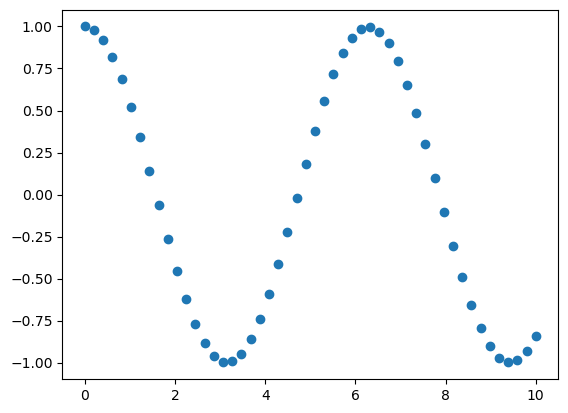

In [5]:
fig, ax = plt.subplots()
ax.scatter(x, y)
plt.show()

Our aim is to evaluate the cosine function at many points.

In [6]:
n = 50_000_000
x = np.linspace(0, 10, n)

### With NumPy

In [7]:
%time np.cos(x)

CPU times: user 389 ms, sys: 32.2 ms, total: 422 ms
Wall time: 421 ms


array([ 1.        ,  1.        ,  1.        , ..., -0.83907175,
       -0.83907164, -0.83907153])

In [8]:
%time np.cos(x)

CPU times: user 388 ms, sys: 35.5 ms, total: 423 ms
Wall time: 422 ms


array([ 1.        ,  1.        ,  1.        , ..., -0.83907175,
       -0.83907164, -0.83907153])

### With JAX

In [9]:
x_jax = jnp.linspace(0, 10, n)

In [10]:
%time jnp.cos(x_jax).block_until_ready()

CPU times: user 54.2 ms, sys: 0 ns, total: 54.2 ms
Wall time: 80 ms


Array([ 1.        ,  1.        ,  1.        , ..., -0.83907205,
       -0.8390716 , -0.8390716 ], dtype=float32)

In [11]:
%time jnp.cos(x_jax).block_until_ready()

CPU times: user 1.29 ms, sys: 0 ns, total: 1.29 ms
Wall time: 974 µs


Array([ 1.        ,  1.        ,  1.        , ..., -0.83907205,
       -0.8390716 , -0.8390716 ], dtype=float32)

Can you explain why the timing changes after we change sizes?

In [12]:
x_jax = jnp.linspace(0, 10, n + 1)

In [13]:
%time jnp.cos(x_jax).block_until_ready()

CPU times: user 53.5 ms, sys: 359 µs, total: 53.9 ms
Wall time: 79.7 ms


Array([ 1.       ,  1.       ,  1.       , ..., -0.8390716, -0.8390716,
       -0.8390716], dtype=float32)

In [14]:
%time jnp.cos(x_jax).block_until_ready()

CPU times: user 672 µs, sys: 164 µs, total: 836 µs
Wall time: 883 µs


Array([ 1.       ,  1.       ,  1.       , ..., -0.8390716, -0.8390716,
       -0.8390716], dtype=float32)

## Evaluating a more complicated function

In [15]:
def f(x):
    y = np.cos(2 * x**2) + np.sqrt(np.abs(x)) + 2 * np.sin(x**4) - 0.1 * x**2
    return y

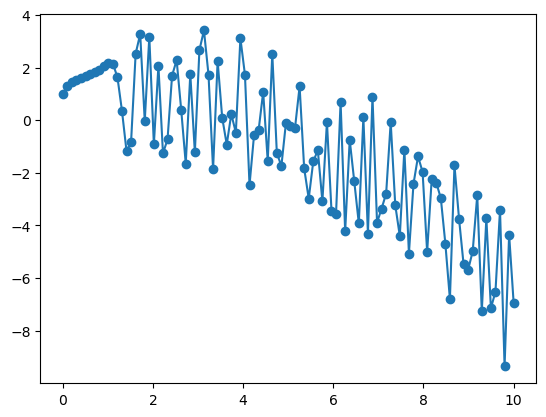

In [16]:
fig, ax = plt.subplots()
x = np.linspace(0, 10, 100)
ax.plot(x, f(x))
ax.scatter(x, f(x))
plt.show()

Now let's try with a large array.

### With NumPy

In [17]:
x = np.linspace(0, 10, n)

In [18]:
%time f(x)

CPU times: user 1.77 s, sys: 184 ms, total: 1.96 s
Wall time: 1.96 s


array([ 1.        ,  1.00044721,  1.00063246, ..., -6.958729  ,
       -6.96024642, -6.96176344])

In [19]:
%time f(x)

CPU times: user 1.71 s, sys: 236 ms, total: 1.94 s
Wall time: 1.94 s


array([ 1.        ,  1.00044721,  1.00063246, ..., -6.958729  ,
       -6.96024642, -6.96176344])

### With JAX

In [20]:
def f(x):
    y = jnp.cos(2 * x**2) + jnp.sqrt(jnp.abs(x)) + 2 * jnp.sin(x**4) - x**2
    return y

In [21]:
x_jax = jnp.linspace(0, 10, n)

In [22]:
%time f(x_jax).block_until_ready()

CPU times: user 230 ms, sys: 0 ns, total: 230 ms
Wall time: 437 ms


Array([  1.       ,   1.0004472,   1.0006324, ..., -96.95619  ,
       -96.96176  , -96.96176  ], dtype=float32)

In [23]:
%time f(x_jax).block_until_ready()

CPU times: user 2.72 ms, sys: 510 µs, total: 3.23 ms
Wall time: 8.59 ms


Array([  1.       ,   1.0004472,   1.0006324, ..., -96.95619  ,
       -96.96176  , -96.96176  ], dtype=float32)

### Compiling the Whole Function

In [24]:
f_jax = jax.jit(f)

In [25]:
%time f_jax(x_jax).block_until_ready()

CPU times: user 51.8 ms, sys: 11.2 ms, total: 63 ms
Wall time: 92.9 ms


Array([  1.       ,   1.0004472,   1.0006324, ..., -96.95619  ,
       -96.96176  , -96.96176  ], dtype=float32)

In [26]:
%time f_jax(x_jax).block_until_ready()

CPU times: user 1.17 ms, sys: 231 µs, total: 1.4 ms
Wall time: 1.16 ms


Array([  1.       ,   1.0004472,   1.0006324, ..., -96.95619  ,
       -96.96176  , -96.96176  ], dtype=float32)

## Solving Linear Systems

In [27]:
np.random.seed(1234)
n = 5_000
A = np.random.randn(n, n)
b = np.ones(n)

In [28]:
%time np.linalg.solve(A, b)

CPU times: user 2.45 s, sys: 55.9 ms, total: 2.51 s
Wall time: 340 ms


array([-0.40884798, -0.06003858,  0.5249821 , ..., -1.21957483,
       -0.04930498, -1.03323347])

In [29]:
A, b = [jax.device_put(v) for v in (A, b)]

In [30]:
%time jnp.linalg.solve(A, b).block_until_ready()

CPU times: user 1.07 s, sys: 29.4 ms, total: 1.1 s
Wall time: 234 ms


Array([-0.4079029 , -0.06066864,  0.5259975 , ..., -1.2188882 ,
       -0.04845167, -1.0332443 ], dtype=float32)

In [31]:
%time jnp.linalg.solve(A, b).block_until_ready()

CPU times: user 2.02 ms, sys: 282 µs, total: 2.3 ms
Wall time: 23 ms


Array([-0.4079029 , -0.06066864,  0.5259975 , ..., -1.2188882 ,
       -0.04845167, -1.0332443 ], dtype=float32)

## Nonlinear Equations

In many cases we want to solve a system of nonlinear equations.

This section gives an example --- solving for an equilibrium price vector when supply and demand are nonlinear.

We start with a simple two good market.

Then we shift up to high dimensions.

We will see that, in high dimensions, automatic differentiation and the GPU are very helpful.

### A Two Goods Market Equilibrium

Let’s start by computing the market equilibrium of a two-good problem.

Our first step is to define the excess demand function

$$
e(p) = 
    \begin{pmatrix}
    e_0(p) \\
    e_1(p)
    \end{pmatrix}
$$

The function below calculates the excess demand for given parameters

In [32]:
def e(p, A, b, c):
    "Excess demand is demand - supply at price vector p"
    return np.exp(- A @ p) + c - b * np.sqrt(p)

Our default parameter values will be

$$
A = \begin{pmatrix}
            0.5 & 0.4 \\
            0.8 & 0.2
        \end{pmatrix},
            \qquad 
    b = \begin{pmatrix}
            1 \\
            1
        \end{pmatrix}
    \qquad \text{and} \qquad
    c = \begin{pmatrix}
            1 \\
            1
        \end{pmatrix}
$$

In [33]:
A = np.array(((0.5, 0.4),
              (0.8, 0.2)))
b = np.ones(2)
c = np.ones(2)

Next we plot the two functions $ e_0 $ and $ e_1 $ on a grid of $ (p_0, p_1) $ values, using contour surfaces and lines.

We will use the following function to build the contour plots

In [34]:
def plot_excess_demand(ax, good=0, grid_size=100, grid_max=4, surface=True):
    p_grid = np.linspace(0, grid_max, grid_size)
    z = np.empty((100, 100))

    for i, p_1 in enumerate(p_grid):
        for j, p_2 in enumerate(p_grid):
            z[i, j] = e((p_1, p_2), A, b, c)[good]

    if surface:
        cs1 = ax.contourf(p_grid, p_grid, z.T, alpha=0.5)
        plt.colorbar(cs1, ax=ax, format="%.6f")

    ctr1 = ax.contour(p_grid, p_grid, z.T, levels=[0.0])
    ax.set_xlabel("$p_0$")
    ax.set_ylabel("$p_1$")
    ax.set_title(f'Excess Demand for Good {good}')
    plt.clabel(ctr1, inline=1, fontsize=13)

Here’s our plot of $ e_0 $:

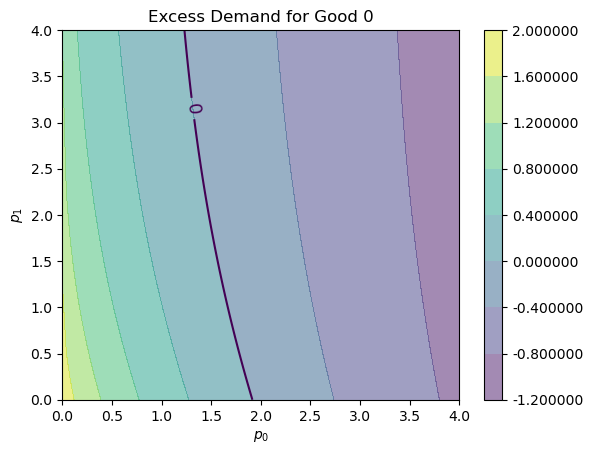

In [35]:
fig, ax = plt.subplots()
plot_excess_demand(ax, good=0)
plt.show()

Here’s our plot of $ e_1 $:

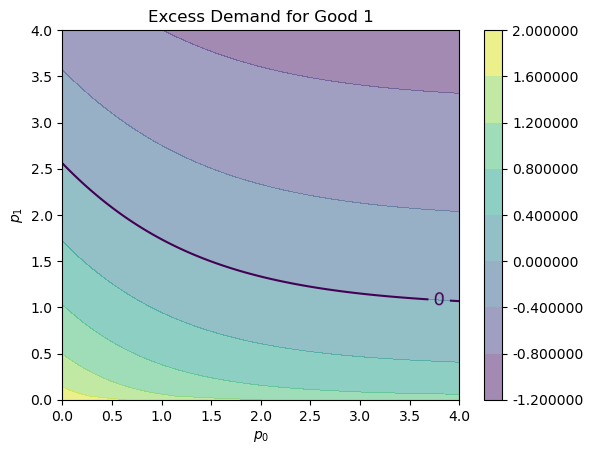

In [36]:
fig, ax = plt.subplots()
plot_excess_demand(ax, good=1)
plt.show()

We see the black contour line of zero, which tells us when $ e_i(p)=0 $.

For a price vector $ p $ such that $ e_i(p)=0 $ we know that good $ i $ is in equilibrium (demand equals supply).

If these two contour lines cross at some price vector $ p^* $, then $ p^* $ is an equilibrium price vector.

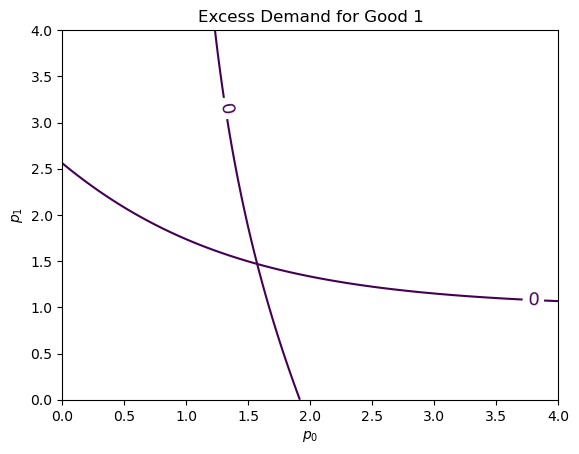

In [37]:
fig, ax = plt.subplots()
for good in (0, 1):
    plot_excess_demand(ax, good=good, surface=False)
plt.show()

It seems there is an equilibrium close to $ p = (1.6, 1.5) $.

#### Using a Multidimensional Root Finder

To solve for $ p^* $ more precisely, we use a zero-finding algorithm from `scipy.optimize`.

We supply $ p = (1, 1) $ as our initial guess.

In [38]:
init_p = np.ones(2)

This uses the [modified Powell method](https://docs.scipy.org/doc/scipy/reference/optimize.root-hybr.html#optimize-root-hybr) to find the zero

In [39]:
%%time
solution = scipy.optimize.root(lambda p: e(p, A, b, c), init_p, method='hybr')

CPU times: user 50.6 ms, sys: 0 ns, total: 50.6 ms
Wall time: 50.5 ms


Here’s the resulting value:

In [40]:
p = solution.x
p

array([1.57080182, 1.46928838])

This looks close to our guess from observing the figure. We can plug it back into $ e $ to test that $ e(p) \approx 0 $:

In [41]:
np.max(np.abs(e(p, A, b, c)))

2.0383694732117874e-13

This is indeed a very small error.

#### Adding Gradient Information

In many cases, for zero-finding algorithms applied to smooth functions, supplying the [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) of the function leads to better convergence properties.

Here we manually calculate the elements of the Jacobian

$$
J(p) = 
    \begin{pmatrix}
        \frac{\partial e_0}{\partial p_0}(p) & \frac{\partial e_0}{\partial p_1}(p) \\
        \frac{\partial e_1}{\partial p_0}(p) & \frac{\partial e_1}{\partial p_1}(p)
    \end{pmatrix}
$$

In [42]:
def jacobian_e(p, A, b, c):
    p_0, p_1 = p
    a_00, a_01 = A[0, :]
    a_10, a_11 = A[1, :]
    j_00 = -a_00 * np.exp(-a_00 * p_0) - (b[0]/2) * p_0**(-1/2)
    j_01 = -a_01 * np.exp(-a_01 * p_1)
    j_10 = -a_10 * np.exp(-a_10 * p_0)
    j_11 = -a_11 * np.exp(-a_11 * p_1) - (b[1]/2) * p_1**(-1/2)
    J = [[j_00, j_01],
         [j_10, j_11]]
    return np.array(J)

In [43]:
solution = scipy.optimize.root(lambda p: e(p, A, b, c),
                init_p, 
                jac=lambda p: jacobian_e(p, A, b, c), 
                method='hybr')

Now the solution is even more accurate (although, in this low-dimensional problem, the difference is quite small):

In [44]:
p = solution.x
np.max(np.abs(e(p, A, b, c)))

1.3322676295501878e-15

#### Newton’s Method via JAX

We use a multivariate version of Newton’s method to compute the equilibrium price.

The rule for updating a guess $ p_n $ of the equilibrium price vector is


<a id='equation-multi-newton'></a>
$$
p_{n+1} = p_n - J_e(p_n)^{-1} e(p_n) \tag{3.1}
$$

Here $ J_e(p_n) $ is the Jacobian of $ e $ evaluated at $ p_n $.

Iteration starts from initial guess $ p_0 $.

Instead of coding the Jacobian by hand, we use automatic differentiation via `jax.jacobian()`.

In [45]:
def newton(f, x_0, tol=1e-5, max_iter=15):
    """
    A multivariate Newton root-finding routine.

    """
    x = x_0
    f_jac = jax.jacobian(f)
    @jax.jit
    def q(x):
        " Updates the current guess. "
        return x - jnp.linalg.solve(f_jac(x), f(x))
    error = tol + 1
    n = 0
    while error > tol:
        n += 1
        if(n > max_iter):
            raise Exception('Max iteration reached without convergence')
        y = q(x)
        error = jnp.linalg.norm(x - y)
        x = y
        print(f'iteration {n}, error = {error}')
    return x

In [46]:
def e(p, A, b, c):
    return jnp.exp(- A @ p) + c - b * jnp.sqrt(p)

In [47]:
p = newton(lambda p: e(p, A, b, c), init_p)
jnp.max(jnp.abs(e(p, A, b, c)))

iteration 1, error = 0.6251485347747803
iteration 2, error = 0.11152244359254837
iteration 3, error = 0.0025770305655896664
iteration 4, error = 1.2894455494461e-06


Array(0., dtype=float32)

### A High-Dimensional Problem

Let’s now apply the method just described to investigate a large market with 5,000 goods.

We randomly generate the matrix $ A $ and set the parameter vectors $ b, c $ to $ 1 $.

In [48]:
dim = 5_000
seed = 32

# Create a random matrix A and normalize the rows to sum to one
key = jax.random.PRNGKey(seed)
A = jax.random.uniform(key, [dim, dim])
s = jnp.sum(A, axis=0)
A = A / s

# Set up b and c
b = jnp.ones(dim)
c = jnp.ones(dim)

Here’s our initial condition $ p_0 $

In [49]:
init_p = jnp.ones(dim)

By combining the power of Newton’s method, JAX accelerated linear algebra,
automatic differentiation, and a GPU, we obtain a relatively small error for
this high-dimensional problem in just a few seconds:

In [50]:
%%time

p = newton(lambda p: e(p, A, b, c), init_p).block_until_ready()

iteration 1, error = 29.977502822875977
iteration 2, error = 5.092787265777588
iteration 3, error = 0.10971497744321823
iteration 4, error = 5.223734115133993e-05
iteration 5, error = 1.1445954442024231e-05
iteration 6, error = 3.996623490820639e-06
CPU times: user 2.74 s, sys: 559 ms, total: 3.3 s
Wall time: 1.66 s


Here’s the size of the error:

In [51]:
jnp.max(jnp.abs(e(p, A, b, c)))

Array(1.1920929e-07, dtype=float32)

With the same tolerance, SciPy’s `root` function takes much longer to run.

In [52]:
%%time

solution = scipy.optimize.root(lambda p: e(p, A, b, c),
                init_p,
                method='hybr',
                tol=1e-5)

CPU times: user 1min 40s, sys: 323 ms, total: 1min 40s
Wall time: 1min 40s


In [53]:
p = solution.x
jnp.max(jnp.abs(e(p, A, b, c)))

Array(4.7683716e-07, dtype=float32)